In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import healpy as hp
import h5py, os
import matplotlib.pyplot as plt
import tensorflow as tf

from msfm.grid_pipeline import GridPipeline
from msfm.fiducial_pipeline import FiducialPipeline
from msfm.utils import cross_statistics, tfrecords, files, maps, power_spectra

24-01-05 09:26:47   imports.py INF   Setting up healpy to run on 8 CPUs 
24-01-05 09:26:48   imports.py INF   Setting up healpy to run on 8 CPUs 
24-01-05 09:26:48   imports.py INF   Setting up healpy to run on 8 CPUs 


In [3]:
bin_indices, bin_names = cross_statistics.get_cross_bin_indices(
    with_lensing=True, 
    with_clustering=False, 
    with_cross_z=True, 
    with_cross_probe=False
)

# from the .tfrecords

In [4]:
# base_dir = "/cluster/work/refregier/athomsen/CosmoGrid/DESY3/v6/debug/smoothed"
# base_dir = "/cluster/work/refregier/athomsen/CosmoGrid/DESY3/v6/debug/original"
base_dir = "/cluster/work/refregier/athomsen/CosmoGrid/DESY3/v6/debug/nonbinned"

with h5py.File(os.path.join(base_dir, "grid_cls.h5")) as f:
    print(f.keys())
    
    grid_cls = f["cls/binned"][:]
    grid_theta = f["cosmo"][:]
    
    grid_i_sobol = f["i_sobol"][:]
    grid_i_example = f["i_example"][:]
    grid_i_noise = f["i_noise"][:]
    
print("\noriginal shape")
print(grid_cls.shape)
print(grid_theta.shape)
print(grid_i_sobol.shape)
print(grid_i_example.shape)
print(grid_i_noise.shape)

# select the right auto and cross bins
print(f"Using the bin indices {bin_indices}")
print(f"With names {bin_names}")
grid_cls = grid_cls[...,bin_indices]

# concatenate the bins along the last axis
grid_cls = np.concatenate([grid_cls[...,i] for i in range(grid_cls.shape[-1])], axis=-1)

print("\nfinal shape")
print(grid_cls.shape)

<KeysViewHDF5 ['cls', 'cosmo', 'i_example', 'i_noise', 'i_sobol']>

original shape
(1, 48, 32, 36)
(1, 48, 10)
(1, 48)
(1, 48)
(1, 48)
Using the bin indices [0, 1, 2, 3, 8, 9, 10, 15, 16, 21]
With names ['bin_0x0' 'bin_0x1' 'bin_0x2' 'bin_0x3' 'bin_1x1' 'bin_1x2' 'bin_1x3'
 'bin_2x2' 'bin_2x3' 'bin_3x3']

final shape
(1, 48, 320)


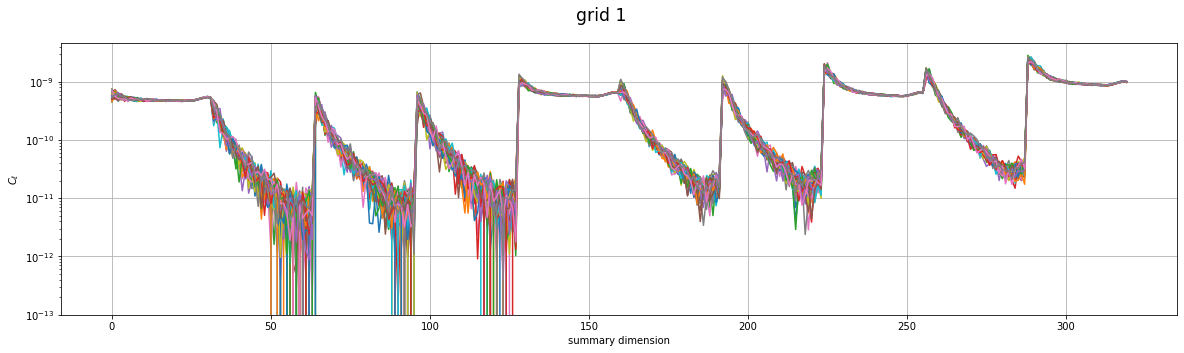

In [5]:
fig, ax = plt.subplots(figsize=(20,5))

# transpose for the matplotlib to handle the 2D vector correctly
ax.plot(grid_cls[0].T)

ax.grid(True)
ax.set(xlabel="summary dimension", ylabel=r"$C_\ell$", yscale="log")
    
fig.suptitle(f"grid {grid_i_sobol[0,0]}", fontsize="xx-large");

# look at the maps directly

In [6]:
# # tfr_file = "/cluster/work/refregier/athomsen/CosmoGrid/DESY3/v6/debug/DESy3smoothed_grid_0000.tfrecord"
# tfr_file = "/cluster/work/refregier/athomsen/CosmoGrid/DESY3/v6/linear_bias/tfrecords/grid/DESy3_grid_000.tfrecord"
# conf = "/cluster/home/athomsen/dlss/repos/multiprobe-simulation-forward-model/configs/v6/linear_bias.yaml"
# conf = files.load_config(conf)

# grid_pipe = GridPipeline(
#     conf=conf,
#     params=["Om", "s8"],
#     with_lensing=True,
#     with_clustering=True,
#     with_padding=True,
#     apply_norm=False
# )

# data_vec_pix = grid_pipe.data_vec_pix
# n_side = conf["analysis"]["n_side"]
# n_pix = conf["analysis"]["n_pix"]
# n_z = grid_pipe.n_z_metacal + grid_pipe.n_z_maglim
# n_z_metacal = grid_pipe.n_z_metacal
# n_noise = 3

# grid_dset = grid_pipe.get_dset(
#     tfr_pattern=tfr_file,
#     n_noise=n_noise,
#     local_batch_size=1,
#     n_readers=1,
#     n_prefetch=0,
# )


### manually call my functions

In [7]:
# cls = []
# for dv, cosmo, index in grid_dset.take(1):
#     hp_map = np.zeros((n_pix, n_z))
#     hp_map[data_vec_pix] = dv[0]
    
#     alm = power_spectra.get_alms(hp_map, nest=True)
#     cl = power_spectra.get_cls(
#         alm,
#         l_mins=conf["analysis"]["scale_cuts"]["lensing"]["l_min"]
#         + conf["analysis"]["scale_cuts"]["clustering"]["l_min"],
#         l_maxs=conf["analysis"]["scale_cuts"]["lensing"]["l_max"]
#         + conf["analysis"]["scale_cuts"]["clustering"]["l_max"],
#         n_bins=conf["analysis"]["power_spectra"]["n_bins"],
#     )
    
#     cl = cl[...,bin_indices]
#     cl = np.concatenate([cl[...,i] for i in range(cl.shape[-1])], axis=-1)

#     cls.append(cl)

# fig, ax = plt.subplots(figsize=(20,5))

# # transpose for the matplotlib to handle the 2D vector correctly
# ax.plot(cl)

# ax.grid(True)
# ax.set(xlabel="summary dimension", ylabel=r"$C_\ell$", yscale="log")

### use healpy directly

In [8]:
# for dv, cosmo, index in grid_dset.take(1):
#     hp_map = np.zeros((n_pix, n_z))
#     hp_map[data_vec_pix] = dv[0]
#     hp_map = maps.tomographic_reorder(hp_map, n2r=True)
    
#     cls = []
#     for i in range(hp_map.shape[1]):
#         for j in range(hp_map.shape[1]):
#             if i <= j:
#                 cls.append(
#                     hp.anafast(
#                         hp_map[:,i],
#                         hp_map[:,j],
#                         lmax=1535,
#                         pol=False,
#                         use_pixel_weights=True
#                     )
#                 )
                
#     cls = np.stack(cls, axis=-1)
    
#     cls = cls[...,bin_indices]
#     cls = np.concatenate([cls[...,i] for i in range(cls.shape[-1])], axis=-1)


# fig, ax = plt.subplots(figsize=(20,5))

# # transpose for the matplotlib to handle the 2D vector correctly
# ax.plot(cls)

# ax.grid(True)
# ax.set(xlabel="summary dimension", ylabel=r"$C_\ell$", yscale="log")

# fiducial

In [9]:
tfr_file = "/cluster/work/refregier/athomsen/CosmoGrid/DESY3/v6/linear_bias/tfrecords/fiducial/DESy3_fiducial_0000.tfrecord"
conf = "/cluster/home/athomsen/dlss/repos/multiprobe-simulation-forward-model/configs/v6/linear_bias.yaml"
conf = files.load_config(conf)

pipe = FiducialPipeline(
    conf=conf,
    params=["Om", "s8"],
    with_lensing=True,
    with_clustering=False,
    with_padding=True,
    apply_norm=False,
    shape_noise_scale=1.0,
    apply_m_bias=False,
    # shape_noise_scale=1000.0,
    # shape_noise_scale=None,
    # poisson_noise_scale=None,
)

data_vec_pix = pipe.data_vec_pix
n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]
n_z = pipe.n_z_metacal + pipe.n_z_maglim
n_z_metacal = pipe.n_z_metacal
n_noise = 3

dset = pipe.get_dset(
    tfr_pattern=tfr_file,
    n_noise=n_noise,
    local_batch_size=1,
    n_readers=1,
    n_prefetch=0,
    is_eval=True,
)


24-01-05 09:26:49     files.py INF   Loaded the pixel file /cluster/home/athomsen/dlss/repos/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 
24-01-05 09:26:49     files.py INF   Loaded the pixel file /cluster/home/athomsen/dlss/repos/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 
24-01-05 09:26:50 fiducial_pip WAR   Evaluation mode is activated: the random seed is fixed, the shuffle arguments ignored, and the dataset is not repeated 
24-01-05 09:26:50 fiducial_pip INF   Interleaving with n_readers = 1 


2024-01-05 09:26:50.362241: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/cluster/apps/nss/gcc-8.2.0/python/3.10.4/x86_64/lib64/python3.10/site-packages/tensorflow/python/data/ops/dataset_ops.py:2210: UserWarning: The `deterministic` argument has no effect unless the `num_parallel_calls` argument is specified.
  warnings.warn("The `deterministic` argument has no effect unless the "


24-01-05 09:26:51 fiducial_pip INF   Batching into 1 elements locally 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
24-01-05 09:26:52 fiducial_pip WAR   Tracing _augmentations 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
24-01-05 09:26:54 fiducial_pip INF   Running on the data_vectors.keys() = dict_keys(['kg_fiducial', 'kg_delta_Om_m', 'kg_delta_Om_p', 'kg_delta_s8_m', 'kg_delta_s8_p', 'i_example', 'sn', 'i_noise']) 
24-01-05 09:26:54 fiducial_pip WAR   Tracing _lensing_augmentations 
24-01-05 09:26:54 fiducial_pip WAR   No multiplicative shear bias is applied 
24-01-05 09:26:54 fiducial_pip WAR   No multiplicative shear bias is applied 
24-01-05 09:26:54 fiducial_pip WAR   No multiplicative shear bias is applied 
24-01-05 09:26:54 fiducial_pip WAR   No multiplicative shear bias is applied 
24-01-05 09:26:54 fiducial_pip WAR   No multipli

[Text(0.5, 0, 'summary dimension'),
 Text(0, 0.5, '$C_\\ell$'),
 None,
 (1e-12, 1e-08)]

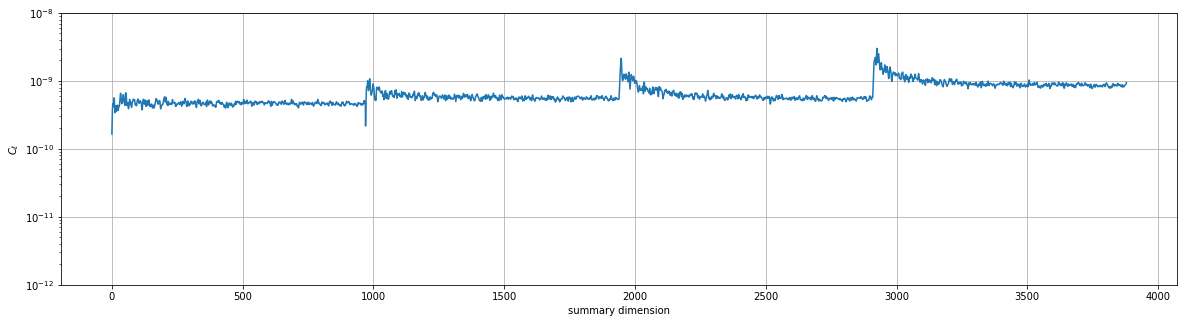

In [10]:
for dv, index in dset.take(1):
    hp_map = np.zeros((n_pix, 4))
    hp_map[data_vec_pix] = dv[0]
    hp_map_ring = maps.tomographic_reorder(hp_map.copy(), n2r=True)
    
    cls = []
    for i in range(4):
        for j in range(4):
            # if i <= j:
            if i == j:
                cls.append(
                    hp.anafast(
                        hp_map_ring[:,i],
                        hp_map_ring[:,j],
                        pol=False,
                        use_pixel_weights=True
                    )[30:1000]
                )
                
    cls = np.stack(cls, axis=-1)
    
    # cls = cls[...,bin_indices]
    cls = np.concatenate([cls[...,i] for i in range(cls.shape[-1])], axis=-1)


fig, ax = plt.subplots(figsize=(20,5))

# transpose for the matplotlib to handle the 2D vector correctly
ax.plot(cls)

ax.grid(True)
ax.set(xlabel="summary dimension", ylabel=r"$C_\ell$", yscale="log", ylim=(1e-12, 1e-8))
# ax.set(xlabel="summary dimension", ylabel=r"$C_\ell$", yscale="log")

In [11]:
# for dv, index in dset.take(1):
#     hp_map = np.zeros((n_pix, n_z))
#     hp_map[data_vec_pix] = dv[0]
#     hp_map = maps.tomographic_reorder(hp_map, n2r=True)
    
#     cls = []
#     for i in range(hp_map.shape[1]):
#         for j in range(hp_map.shape[1]):
#             if i <= j:
#                 cls.append(
#                     hp.anafast(
#                         hp_map[:,i],
#                         hp_map[:,j],
#                         lmax=1535,
#                         pol=False,
#                         use_pixel_weights=True
#                     )
#                 )
                
#     cls = np.stack(cls, axis=-1)
    
#     cls = cls[...,bin_indices]
#     cls = np.concatenate([cls[...,i] for i in range(cls.shape[-1])], axis=-1)


# fig, ax = plt.subplots(figsize=(20,5))

# # transpose for the matplotlib to handle the 2D vector correctly
# ax.plot(cls)

# ax.grid(True)
# ax.set(xlabel="summary dimension", ylabel=r"$C_\ell$", yscale="log", ylim=(1e-12, 1e-8))

In [12]:
dv.shape

TensorShape([5, 464896, 4])

In [13]:
# for dv, index in dset.take(1):
#     hp_map = np.zeros((n_pix, n_z))
#     hp_map[data_vec_pix] = dv[0]
#     hp_map = maps.tomographic_reorder(hp_map, n2r=True)
    
#     cls = []
#     for i in range(hp_map.shape[1]):
#         for j in range(hp_map.shape[1]):
#             if i <= j:
#                 cls.append(
#                     hp.anafast(
#                         hp_map[:,i],
#                         hp_map[:,j],
#                         lmax=1535,
#                         pol=False,
#                         use_pixel_weights=True
#                     )
#                 )
                
#     cls = np.stack(cls, axis=-1)
    
#     cls = cls[...,bin_indices]
#     cls = np.concatenate([cls[...,i] for i in range(cls.shape[-1])], axis=-1)


# fig, ax = plt.subplots(figsize=(20,5))

# # transpose for the matplotlib to handle the 2D vector correctly
# ax.plot(cls)

# ax.grid(True)
# ax.set(xlabel="summary dimension", ylabel=r"$C_\ell$", yscale="log")